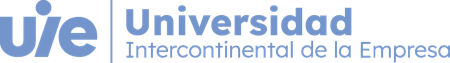

**G25GXX3.10X. Aprendizaje Automático**

**Profesor: Borja González Seoane**

Curso 2025-26

In [366]:
__author__ = "Alex Caride Cid"

# PLD6. Clusterización de datos reales con *K-means*

En esta práctica se utilizará la implementación de *K-means* _scracth_ alcanzada en el _notebook_ anterior, la cual será contrastada con la implementación de la librería Scikit-Learn. Para poner a prueba los algoritmos de clusterización, se utilizará el conjunto de datos [_Facebook Live Sellers in Thailand_](https://archive.ics.uci.edu/dataset/488/facebook+live+sellers+in+thailand) de UCI Machine Learning Repository. Este conjunto de datos describe transmisiones en vivo de vendedores tailandeses en Facebook.

Se debe importar el conjunto de datos, realizar un breve EDA para entender la estructura de los datos y proceder con las correspondientes transformaciones. Posteriormente, se deberán utilizar las implementaciones de *K-means* mencionadas usando el método del codo para determinar el número óptimo de clústeres.


In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import ucimlrepo

In [368]:
TEST_SPLIT_SIZE = 0.2
RANDOM_STATE = 23

# Set NumPy's random seed
np.random.seed(RANDOM_STATE)

## Carga del conjunto de datos

In [369]:
# Carga de datos Facebook Live Sellers in Thailand de UCI ML Repository
data_file = "Live_20210128.csv"
df = pd.read_csv(data_file)

display(df)

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,1,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,2,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,3,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,4,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,5,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7045,7046,photo,9/24/2016 2:58,89,0,0,89,0,0,0,0,0,NaN,NaN,NaN,NaN
7046,7047,photo,9/23/2016 11:19,16,0,0,14,1,0,1,0,0,NaN,NaN,NaN,NaN
7047,7048,photo,9/21/2016 23:03,2,0,0,1,1,0,0,0,0,NaN,NaN,NaN,NaN
7048,7049,photo,9/20/2016 0:43,351,12,22,349,2,0,0,0,0,NaN,NaN,NaN,NaN


## EDA del conjunto de datos

Detección y tratamiento de valores nulos, _outliers_, etc. Eliminación de columnas no relevantes.

In [370]:
print(df.columns)

Index(['status_id', 'status_type', 'status_published', 'num_reactions',
       'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows',
       'num_hahas', 'num_sads', 'num_angrys', 'Column1', 'Column2', 'Column3',
       'Column4'],
      dtype='object')


In [371]:
df.dtypes

status_id             int64
status_type          object
status_published     object
num_reactions         int64
num_comments          int64
num_shares            int64
num_likes             int64
num_loves             int64
num_wows              int64
num_hahas             int64
num_sads              int64
num_angrys            int64
Column1             float64
Column2             float64
Column3             float64
Column4             float64
dtype: object

In [372]:
# Eliminamos columnas irrelevantes
columnas_eliminar = [
    "Column1", "Column2", "Column3", "Column4",  "status_id", "num_reactions"                               
]
df = df.drop(columns=columnas_eliminar)

In [373]:
# Eliminamos duplicados
df = df.drop_duplicates(keep='first')

In [374]:
# Comprobamos datos nulos
print(df.isnull().sum())

status_type         0
status_published    0
num_comments        0
num_shares          0
num_likes           0
num_loves           0
num_wows            0
num_hahas           0
num_sads            0
num_angrys          0
dtype: int64


In [375]:
# Comprobamos outliers de las variables numéricas
columnas_numericas = df.select_dtypes(include=['int64', 'float64']).columns
for columna in columnas_numericas:
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    print(f"Columna: {columna}, Número de outliers: {outliers.shape[0]}")



Columna: num_comments, Número de outliers: 1365
Columna: num_shares, Número de outliers: 1382
Columna: num_likes, Número de outliers: 754
Columna: num_loves, Número de outliers: 1303
Columna: num_wows, Número de outliers: 1702
Columna: num_hahas, Número de outliers: 1117
Columna: num_sads, Número de outliers: 598
Columna: num_angrys, Número de outliers: 420


In [376]:
# Columnas categoricas
columnas_categoricas = df.select_dtypes(include=['object']).columns
print("Columnas categóricas:", columnas_categoricas.tolist())

Columnas categóricas: ['status_type', 'status_published']


## Codificación de variables categóricas

In [377]:
# Transformamos en dummies mediante one_hot_encoding
columnas_a_codificar = ["status_type"]
columnas_a_codificar = [c for c in columnas_a_codificar if c in df.columns]

df = pd.get_dummies(df, columns=columnas_a_codificar, drop_first=True)

In [378]:
# Convertimos status_published en días desde la publicación
df['status_published'] = pd.to_datetime(df['status_published'])
df['dias_desde_publicacion'] = (pd.Timestamp.now() - df['status_published']).dt.days
df = df.drop(columns=['status_published'])
display(df)

,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_photo,status_type_status,status_type_video,dias_desde_publicacion
0,512,262,432,92,3,1,1,0,False,False,True,2772
1,0,0,150,0,0,0,0,0,True,False,False,2772
2,236,57,204,21,1,1,0,0,False,False,True,2773
3,0,0,111,0,0,0,0,0,True,False,False,2773
4,0,0,204,9,0,0,0,0,True,False,False,2776
...,...,...,...,...,...,...,...,...,...,...,...,...
7045,0,0,89,0,0,0,0,0,True,False,False,3347
7046,0,0,14,1,0,1,0,0,True,False,False,3348
7047,0,0,1,1,0,0,0,0,True,False,False,3349
7048,12,22,349,2,0,0,0,0,True,False,False,3351


In [379]:
# Convterimos en binario las columnas booleanas
columnas_booleanas = df.select_dtypes(include=['bool']).columns
for columna in columnas_booleanas:
    df[columna] = df[columna].astype(int)
display(df)

,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_photo,status_type_status,status_type_video,dias_desde_publicacion
0,512,262,432,92,3,1,1,0,0,0,1,2772
1,0,0,150,0,0,0,0,0,1,0,0,2772
2,236,57,204,21,1,1,0,0,0,0,1,2773
3,0,0,111,0,0,0,0,0,1,0,0,2773
4,0,0,204,9,0,0,0,0,1,0,0,2776
...,...,...,...,...,...,...,...,...,...,...,...,...
7045,0,0,89,0,0,0,0,0,1,0,0,3347
7046,0,0,14,1,0,1,0,0,1,0,0,3348
7047,0,0,1,1,0,0,0,0,1,0,0,3349
7048,12,22,349,2,0,0,0,0,1,0,0,3351


## Escalado de variables

*K-means* es un algoritmo basado en distancias, por lo que es conveniente escalar las variables para que todas tengan el mismo peso.

In [380]:
# Escalamos las variables para que todas tengan el mismo peso
columnas_numericas = [
    "num_comments", "num_shares", "num_likes",
    "num_loves", "num_wows", "num_hahas", "num_sads", "num_angrys"
]
df_num = df[columnas_numericas]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_escalado = scaler.fit_transform(df_num)
df_escalado = pd.DataFrame(df_escalado, columns=columnas_numericas)
display(df_escalado)

,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,0.320713,1.678925,0.504931,1.975556,0.200140,0.075978,0.517985,-0.160026
1,-0.252726,-0.304974,-0.136574,-0.318037,-0.143631,-0.175819,-0.157094,-0.160026
2,0.011593,0.126637,-0.013733,0.205501,-0.029041,0.075978,-0.157094,-0.160026
3,-0.252726,-0.304974,-0.225293,-0.318037,-0.143631,-0.175819,-0.157094,-0.160026
4,-0.252726,-0.304974,-0.013733,-0.093663,-0.143631,-0.175819,-0.157094,-0.160026
...,...,...,...,...,...,...,...,...
6991,-0.252726,-0.304974,-0.275339,-0.318037,-0.143631,-0.175819,-0.157094,-0.160026
6992,-0.252726,-0.304974,-0.445952,-0.293106,-0.143631,0.075978,-0.157094,-0.160026
6993,-0.252726,-0.304974,-0.475525,-0.293106,-0.143631,-0.175819,-0.157094,-0.160026
6994,-0.239286,-0.138387,0.316119,-0.268176,-0.143631,-0.175819,-0.157094,-0.160026


## Clusterización usando _K-means_ _Scratch_

Úsese el método de Elbow para determinar el número óptimo de clústeres.

In [381]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inercias = []
K = range(1, 11)  # probar k = 1 a 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_escalado)
    inercias.append(kmeans.inertia_)


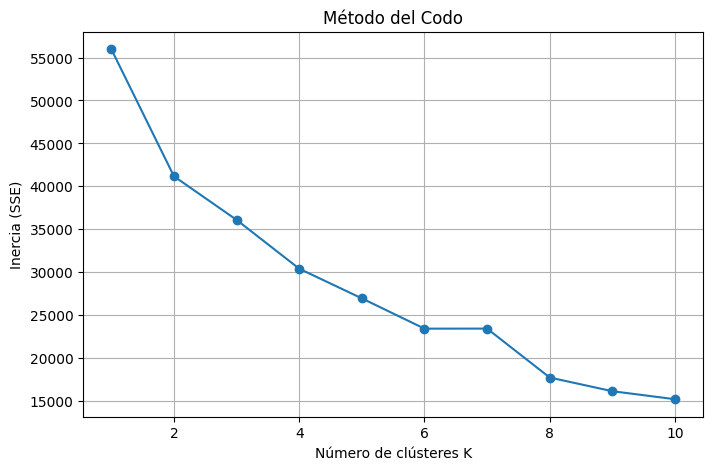

In [382]:
plt.figure(figsize=(8, 5))
plt.plot(K, inercias, marker='o')
plt.xlabel("Número de clústeres K")
plt.ylabel("Inercia (SSE)")
plt.title("Método del Codo")
plt.grid(True)
plt.show()


In [383]:
# Ponemos la función que creamos para graficar los clústeres en 3d
from typing import Optional
from matplotlib import cm
def plot_data_3D(
    data: np.ndarray, labels: Optional[np.ndarray] = None, title: Optional[str] = None
) -> None:
    """
    Función auxiliar para graficar datos en 3D. Se espera que `X` tenga 3 columnas.

    :param X: Datos a graficar.
    :param labels: Etiquetas de los datos, para colorearlos. Si no se proveen, los datos se grafican en un único color.
    :param title: Título del gráfico.
    """
    assert data.shape[1] == 3, "Se esperan 3 columnas en X."

    # Use Seaborn style
    plt.style.use("default")
    # Ignore the Matplotlib deprecation warnings
    plt.rcParams.update({"figure.max_open_warning": 0})

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    if labels is None:
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=100)
    else:
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, s=100, cmap=cm.jet)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    if title is not None:
        ax.set_title(title)

    plt.show()

In [384]:
# Pegamos el k-means from sracth que realizamos en la práctica anterior
from typing import Optional, Literal
class KMeansScratch:
    def __init__(
        self,
        k: int,
        max_iter: int = 1000,
        random_state: Optional[int] = None,
        tol: float = 1e-4,  # Tolerancia para la convergencia. Frobenius
        init: Literal["random", "k-means++"] = "random",
    ):
        # Validación de parámetros
        # k, max_iter: enteros positivos
        # tol: positivo

        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol
        self.init = init

        self._centroides = None
        self._labels = None
        self._inertia = None
        self._n_iter = 0
    
    def __inicializa_centroides(self, X: np.ndarray) -> np.ndarray:
        rng = np.random.default_rng(self.random_state)
        if self.init == "random":
           return self.__inicializa_centroides_random(X, rng)
        elif self.init == "k-means++":
           return self.__inicializa_centroides_mas_mas(X, rng)
        else:
           raise ValueError(f"Método de inicialización '{self.init}' no soportado.")
        
        
    def __inicializa_centroides_random(self, X: np.ndarray,
        rng: np.random.Generator
    ) -> np.ndarray:
        indices = rng.choice(X.shape[0], self.k, replace=False)
        return X[indices].copy()
    
    
    def __inicializa_centroides_mas_mas(self, X: np.ndarray,
       rng: np.random.Generator
    ) -> np.ndarray:
        centroides = np.zeros((self.k, X.shape[1]))
        
        # Elegimos el primer centroide aleatoriamente
        indices = rng.choice(X.shape[0], 1, replace=False)
        centroides[0] = X[indices].copy()
        
        for k in range(1, self.k):
            # Calculamos la distancia mínima de cada punto a los centroides ya elegidos
            distancias = np.min(
                np.sum((X[:, np.newaxis, :] - centroides[np.newaxis, :k, :]) ** 2, axis=2),
                axis=1
            )
            # Probabilidad proporcional a la distancia al cuadrado
            probabilidad = distancias / np.sum(distancias)
            indice_elegido = rng.choice(X.shape[0], 1, p=probabilidad)
            centroides[k] = X[indice_elegido].copy()
        
        return centroides


    def __asignar_clusteres(self, X: np.ndarray) -> np.ndarray:
        
        distancias = np.zeros((X.shape[0], self.k))

        for k in range(self.k):
            # Distancia a cada punto con respecto al centroide 'k'
            distancias[:, k] = np.sum((X - self._centroides[k]) ** 2, axis=1)

        return np.argmin(distancias, axis=1)
    

    def __actualizar_centroides(self, X: np.ndarray,
                                 clusteres: np.ndarray) -> np.ndarray:
        centroides = np.zeros(
            (self.k, X.shape[1]))
        
        for k in range(self.k):
            mask = clusteres == k

            centroides[k] = np.mean(X[mask], axis=0)
            
        return centroides


    

    def __convergencia_frobenius(self,
                                centroides_antiguos: np.ndarray,
                                centroides_nuevos: np.ndarray,
                                tol: float) -> bool:
        norma_frobenius = np.linalg.norm(
            centroides_nuevos - centroides_antiguos,
              ord='fro')
        return bool(norma_frobenius < tol)


    def fit(self, X: np.ndarray):
        self._centroides = self.__inicializa_centroides(X)
        self._n_iter = 0

        for iter_n in range(self.max_iter):
            self._n_iter += 1

            # Asignamos clusters
            self._labels = self.__asignar_clusteres(X)

            # Actualizamos centroides
            centroides_nuevos = self.__actualizar_centroides(X, self._labels)

            if self.__convergencia_frobenius(self._centroides,
                 centroides_nuevos,
                 self.tol):
                break
            self._centroides = centroides_nuevos

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self._centroides is None:
            raise ValueError("El modelo no ha sido entrenado todavía. Llámase a 'fit()' primero.")
        
        return self.__asignar_clusteres(X)

        

In [385]:
kmeans = KMeansScratch(k=4,random_state=RANDOM_STATE,  init="random")
kmeans.fit(df_escalado.values)       
labels_train = kmeans.predict(df_escalado.values)


In [386]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_3d_pca = pca.fit_transform(df_escalado)



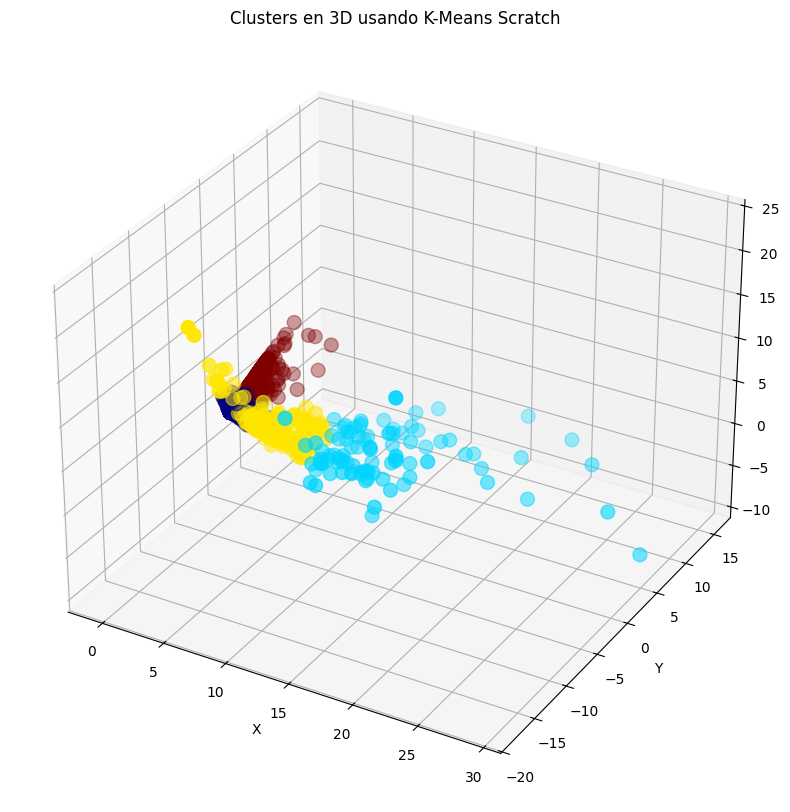

In [387]:
plot_data_3D(
    data=X_3d_pca,
    labels=labels_train,
    title="Clusters en 3D usando K-Means Scratch"
)


## Clusterización usando _K-means_ de Scikit-Learn

In [392]:
# Hacemos los clusters con KMeans de sklearn para comparar
kmeans_sklearn = KMeans(n_clusters=4, random_state=RANDOM_STATE, init="random")
kmeans_sklearn.fit(df_escalado.values)
labels_sklearn = kmeans_sklearn.predict(df_escalado.values)

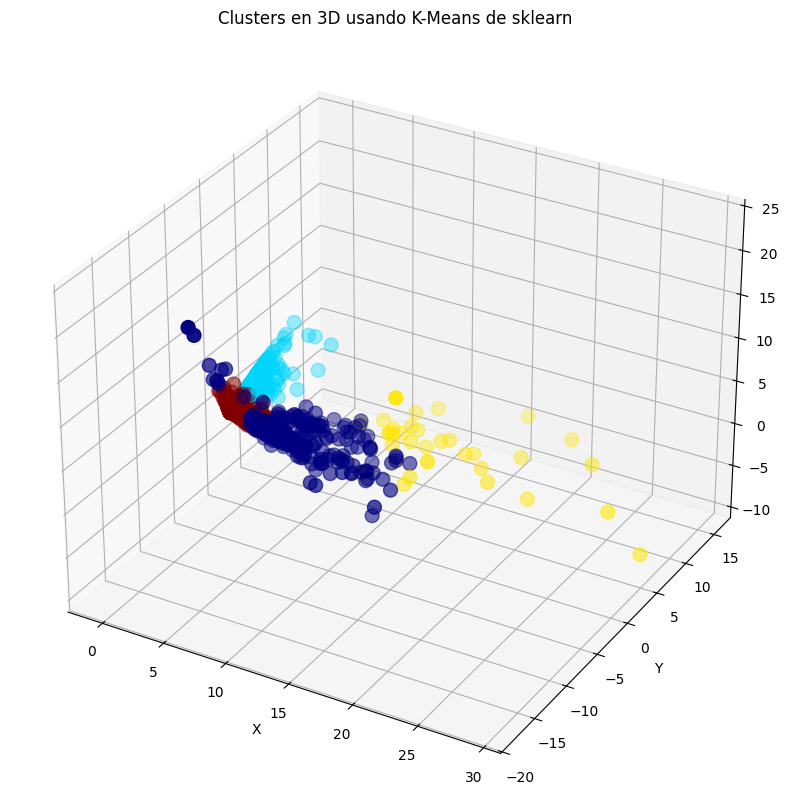

In [393]:
# Lo garficamos también
plot_data_3D(
    data=X_3d_pca,
    labels=labels_sklearn,
    title="Clusters en 3D usando K-Means de sklearn"
)

### Prueba con inicialización `k-means++`

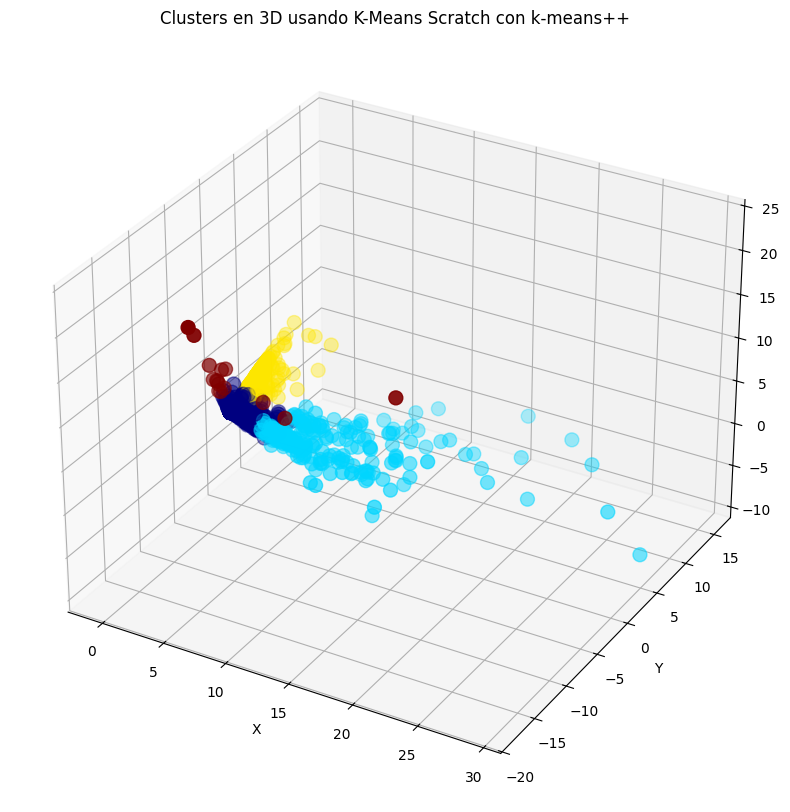

In [394]:
# Ahora probamos con init="k-means++"
kmeans_mas_mas = KMeansScratch(k=4, random_state=RANDOM_STATE, init="k-means++")
kmeans_mas_mas.fit(df_escalado.values)
labels_mas_mas = kmeans_mas_mas.predict(df_escalado.values)
# Lo graficamos
plot_data_3D(
    data=X_3d_pca,
    labels=labels_mas_mas,
    title="Clusters en 3D usando K-Means Scratch con k-means++"
)

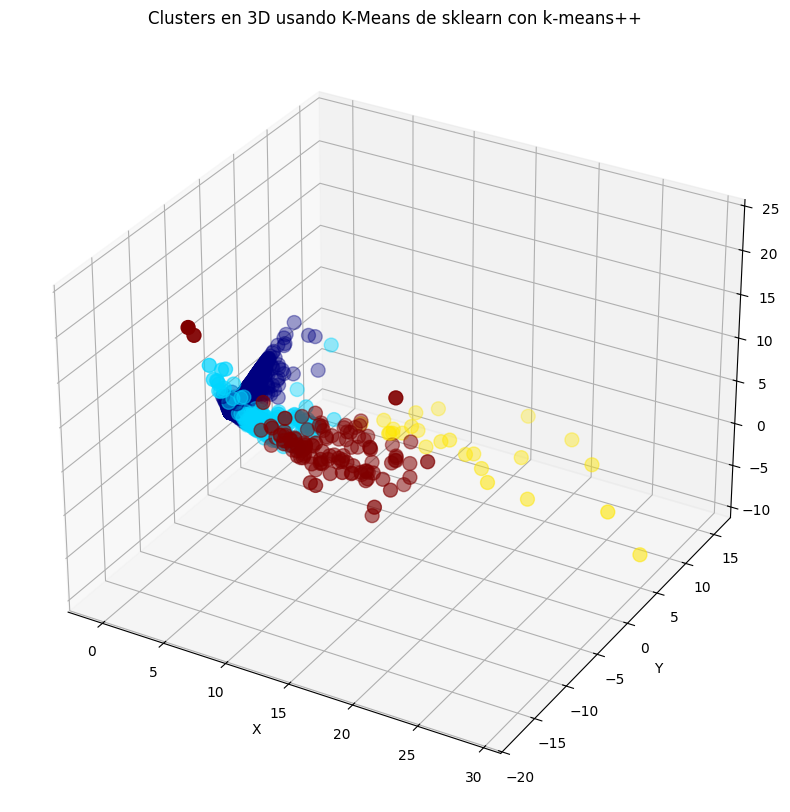

In [395]:
# Lo mismo con sklearn
kmeans_sklearn_mas_mas = KMeans(n_clusters=4, random_state=RANDOM_STATE, init="k-means++")
kmeans_sklearn_mas_mas.fit(df_escalado.values)
labels_sklearn_mas_mas = kmeans_sklearn_mas_mas.predict(df_escalado.values)
# Lo graficamos
plot_data_3D(
    data=X_3d_pca,
    labels=labels_sklearn_mas_mas,
    title="Clusters en 3D usando K-Means de sklearn con k-means++"
)

## Explicabilidad de los clústeres

Comprobación de la distribución de instancias en los clústeres y caracterización de los mismos.

In [396]:
# Comprobamos la distribución de las instacias en los distintos clusters y caracterizamos estos clusters
unique, counts = np.unique(labels_train, return_counts=True)
print("Distribución de instancias en los clusters (K-Means Scratch, init=random):")
print(dict(zip(unique, counts)))
unique, counts = np.unique(labels_sklearn, return_counts=True)
print("Distribución de instancias en los clusters (K-Means sklearn, init=random): ")
print(dict(zip(unique, counts)))
unique, counts = np.unique(labels_mas_mas, return_counts=True)
print("Distribución de instancias en los clusters (K-Means Scratch, init=k-means++):")
print(dict(zip(unique, counts)))
unique, counts = np.unique(labels_sklearn_mas_mas, return_counts=True)
print("Distribución de instancias en los clusters (K-Means sklearn, init=k-means++): ")
print(dict(zip(unique, counts)))


Distribución de instancias en los clusters (K-Means Scratch, init=random):
{np.int64(0): np.int64(5912), np.int64(1): np.int64(95), np.int64(2): np.int64(614), np.int64(3): np.int64(375)}
Distribución de instancias en los clusters (K-Means sklearn, init=random): 
{np.int32(0): np.int64(377), np.int32(1): np.int64(375), np.int32(2): np.int64(34), np.int32(3): np.int64(6210)}
Distribución de instancias en los clusters (K-Means Scratch, init=k-means++):
{np.int64(0): np.int64(6342), np.int64(1): np.int64(264), np.int64(2): np.int64(375), np.int64(3): np.int64(15)}
Distribución de instancias en los clusters (K-Means sklearn, init=k-means++): 
{np.int32(0): np.int64(6172), np.int32(1): np.int64(677), np.int32(2): np.int64(25), np.int32(3): np.int64(122)}


In [398]:
# Caracterización de los clusters
df_clusters = df.copy()
df_clusters['cluster'] = labels_train
display(df_clusters.groupby('cluster').mean())


,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_photo,status_type_status,status_type_video,dias_desde_publicacion
cluster,,,,,,,,,,,,
0,39.488498,8.148342,95.728180,3.228180,0.460589,0.187754,0.074932,0.018437,0.677605,0.047023,0.267084,3319.619249
1,3874.242105,732.421053,938.494737,245.315789,43.178947,16.905263,2.757895,2.557895,0.031579,0.000000,0.968421,2790.473684
2,1556.635179,260.324104,250.026059,74.809446,1.903909,3.439739,1.488599,0.679153,0.045603,0.003257,0.951140,2874.412052
3,56.949333,11.141333,1762.130667,2.466667,2.066667,0.152000,0.024000,0.005333,0.546667,0.210667,0.205333,3702.714667


In [399]:
# Caracterización de los clusters
df_clusters = df.copy()
df_clusters['cluster'] = labels_mas_mas
display(df_clusters.groupby('cluster').mean())

,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_photo,status_type_status,status_type_video,dias_desde_publicacion
cluster,,,,,,,,,,,,
0,107.221539,21.884737,101.478083,7.514822,0.527436,0.348786,0.119048,0.052665,0.633239,0.044150,0.314885,3288.687638
1,3291.916667,522.450758,605.844697,151.662879,17.363636,9.806818,1.890152,1.598485,0.034091,0.000000,0.965909,2849.109848
2,56.949333,11.141333,1762.130667,2.466667,2.066667,0.152000,0.024000,0.005333,0.546667,0.210667,0.205333,3702.714667
3,547.866667,58.133333,340.066667,41.666667,4.333333,1.800000,24.333333,0.866667,0.800000,0.000000,0.200000,3103.400000


In [400]:
# Caracterización de los clusters
df_clusters = df.copy()
df_clusters['cluster'] = labels_sklearn
display(df_clusters.groupby('cluster').mean())

,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_photo,status_type_status,status_type_video,dias_desde_publicacion
cluster,,,,,,,,,,,,
0,2748.031830,394.175066,418.453581,108.103448,3.726790,5.419098,2.265252,1.251989,0.058355,0.000000,0.941645,2878.076923
1,56.949333,11.141333,1762.130667,2.466667,2.066667,0.152000,0.024000,0.005333,0.546667,0.210667,0.205333,3702.714667
2,1718.500000,750.264706,1088.617647,298.205882,101.941176,29.058824,2.970588,1.823529,0.029412,0.000000,0.970588,2767.794118
3,74.532367,16.663285,98.848309,6.027214,0.502899,0.289372,0.106924,0.037842,0.646377,0.045089,0.300644,3297.332206


In [401]:
# Caracterización de los clusters
df_clusters = df.copy()
df_clusters['cluster'] = labels_sklearn_mas_mas
display(df_clusters.groupby('cluster').mean())

,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_photo,status_type_status,status_type_video,dias_desde_publicacion
cluster,,,,,,,,,,,,
0,32.413318,5.830849,195.330363,2.439242,0.544394,0.151653,0.066105,0.011017,0.681141,0.057518,0.251134,3351.476507
1,1148.124077,229.122600,221.174298,68.310192,1.645495,2.865583,1.029542,0.581979,0.044313,0.005908,0.949778,2869.903988
2,1618.840000,819.920000,1134.280000,317.200000,127.560000,20.840000,1.480000,1.840000,0.000000,0.000000,1.000000,2765.400000
3,4596.991803,575.147541,702.836066,164.073770,9.065574,12.196721,3.983607,2.155738,0.065574,0.000000,0.934426,2841.950820


### K-means Scratch Random
Clúster 0 (azul oscuro):
Publicaciones mayoritariamente normales, con niveles muy bajos de interacción y sin destacar en ninguna reacción.

Clúster 1 (granate):
Publicaciones con un engagement extremadamente alto, principalmente vídeos muy comentados, muy compartidos y con abundantes reacciones positivas.

Clúster 2 (amarillo):
Publicaciones de alto impacto, con un volumen considerable de comentarios y compartidos, y un nivel importante de reacciones positivas, aunque no alcanzan la viralidad máxima.

Clúster 3 (celeste):
Publicaciones con muchos likes pero con escaso nivel de comentarios y compartidos, representando contenido ligero o de fácil consumo con interacción superficial.

### K-means Sractch Mas Mas

Clúster 0 (azul oscuro):
Publicaciones de interacción baja, con pocos likes, algunos comentarios y casi sin reacciones emocionales, mayoritariamente fotos y contenido estándar.

Clúster 1 (granate):
Publicaciones de altísimo engagement, principalmente vídeos muy comentados y compartidos, con una abundante cantidad de reacciones positivas y gran difusión.

Clúster 2 (amarillo):
Publicaciones con un número extremadamente alto de likes pero con pocos comentarios y compartidos, reflejando contenido atractivo pero de interacción superficial.

Clúster 3 (celeste):
Publicaciones con niveles moderados de interacción pero con un aumento notable de reacciones negativas y tristes, posiblemente vinculadas a contenido sensible o emocionalmente cargado.

### K-means sklearn Random
Clúster 0 (granate):

Publicaciones con un engagement muy elevado, principalmente vídeos altamente comentados y compartidos, con un volumen importante de reacciones positivas (especialmente loves y wows).

Clúster 1 (celeste):

Publicaciones con muchos likes pero con muy pocos comentarios y compartidos, reflejando contenido ligero, fácil de consumir y de interacción superficial.

Clúster 2 (azul oscuro):

Publicaciones de interacción moderada, con cierta actividad en comentarios y compartidos, y una distribución equilibrada de reacciones, típicamente contenido estándar con recepción variada.

Clúster 3 (amarillo):

Publicaciones de alto impacto, con un número muy elevado de comentarios y compartidos y un fuerte peso de reacciones positivas, situándose muy cerca del perfil viral.

### K-means sklearn Mas Mas
Clúster 0 (azul oscuro):

Publicaciones con interacción moderada, con una mezcla equilibrada de likes, comentarios y compartidos, predominando las fotos y con presencia notable de contenido estándar.

Clúster 1 (celeste):

Publicaciones con un volumen muy elevado de likes pero con escasa participación en comentarios y compartidos, indicando contenido ligero, visual o de consumo rápido que genera muchas reacciones superficiales.

Clúster 2 (granate):

Publicaciones con un engagement muy alto, principalmente vídeos muy comentados y ampliamente compartidos, que acumulan numerosas reacciones positivas, situándose cerca del patrón viral.

Clúster 3 (amarillo):

Publicaciones extremadamente virales, con cifras muy elevadas de comentarios, compartidos y reacciones positivas, siendo el contenido de mayor impacto e interacción del conjunto.